In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.spatial.distance import pdist, squareform


In [15]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [17]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [23]:
# Drop missing CustomerID
retail = df.dropna(subset=['CustomerID'])

# Add TotalPrice column manually
retail['TotalPrice'] = retail['Quantity'] * retail['UnitPrice']

# Feature Engineering: recency, frequency, monetary (RFM)
rfm = retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (retail['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [24]:
# Normalizing the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

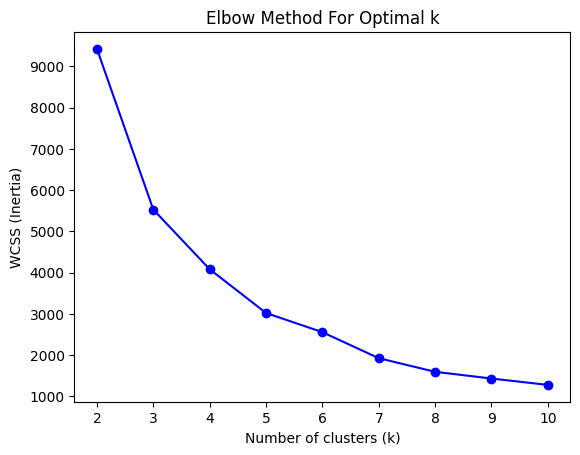

In [25]:
# 1. Elbow Method - To determine the optimal number of clusters for KMeans
# Using KMeans clustering with different numbers of clusters
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [41]:
# 2. Fit KMeans & Agglomerative Clustering with chosen k (e.g., 4)
k_optimal = 4

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

agglo = AgglomerativeClustering(n_clusters=k_optimal)
rfm['Cluster_Agglomerative'] = agglo.fit_predict(rfm_scaled)


In [42]:
# 3. Metrics Evaluation
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)

    intra_dists = []
    for c in unique_clusters:
        intra = distances[np.ix_(labels == c, labels == c)]
        if intra.shape[0] > 1:
            intra_dists.append(np.max(intra))
    max_intra_dist = np.max(intra_dists)

    inter_dists = []
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            inter = distances[np.ix_(labels == unique_clusters[i], labels == unique_clusters[j])]
            inter_dists.append(np.min(inter))
    min_inter_dist = np.min(inter_dists)

    return min_inter_dist / max_intra_dist

In [43]:
models = ['KMeans', 'Agglomerative']
scores = {}

for model in models:
    cluster_label = 'Cluster_' + model
    labels = rfm[cluster_label]

    silhouette = silhouette_score(rfm_scaled, labels)
    calinski = calinski_harabasz_score(rfm_scaled, labels)
    davies = davies_bouldin_score(rfm_scaled, labels)
    dunn = dunn_index(rfm_scaled, labels)

    scores[model] = {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': calinski,
        'Davies-Bouldin Index': davies,
        'Dunn Index': dunn
    }

scores_df = pd.DataFrame(scores).T
scores_df


,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,Dunn Index
KMeans,0.614280,3222.798251,0.744038,0.000581
Agglomerative,0.589313,2908.521543,0.593654,0.000737


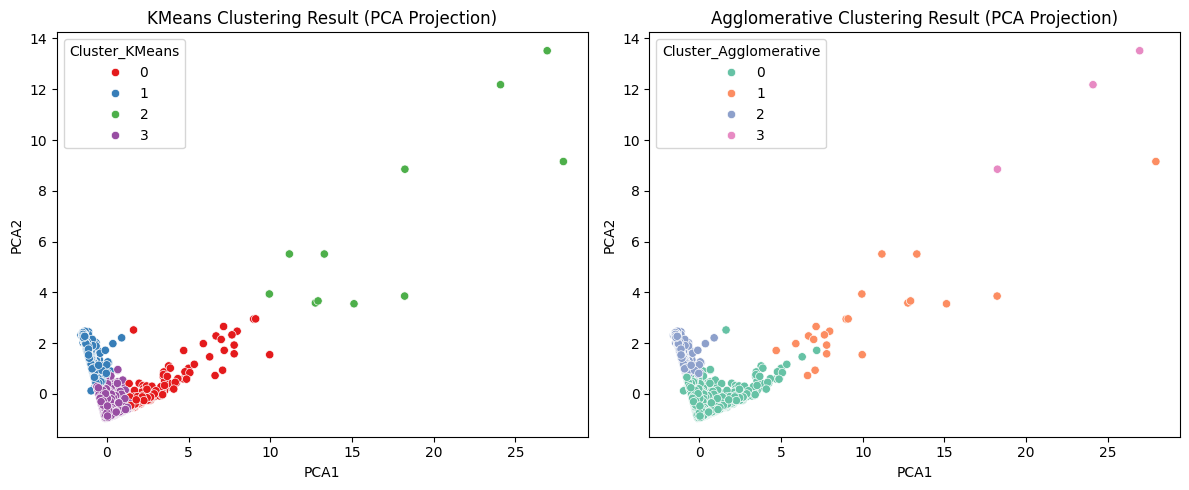

In [44]:
# 4. Visualization of Clustering Results

from sklearn.decomposition import PCA

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Plotting KMeans Clusters
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster_KMeans',
    palette='Set1',
    data=rfm,
    legend='full'
)
plt.title('KMeans Clustering Result (PCA Projection)')

# Plotting Agglomerative Clusters
plt.subplot(1,2,2)
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Cluster_Agglomerative',
    palette='Set2',
    data=rfm,
    legend='full'
)
plt.title('Agglomerative Clustering Result (PCA Projection)')

plt.tight_layout()
plt.show()


## Silhouette Coefficient
Silhouette score mengukur seberapa mirip suatu titik dengan cluster-nya sendiri dibandingkan dengan cluster lain.

\[
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

- \( a(i) \): rata-rata jarak titik \(i\) ke semua titik lain dalam cluster yang sama.
- \( b(i) \): jarak rata-rata terkecil titik \(i\) ke semua titik di cluster lain.

Nilai mendekati 1 berarti cluster bagus, mendekati -1 berarti buruk.

## Calinski-Harabasz Index
Mengukur rasio antara dispersi antar-cluster terhadap dispersi intra-cluster.

\[
CH = \frac{Tr(B_k) / (k-1)}{Tr(W_k) / (n-k)}
\]

- \( Tr(B_k) \): trace dari matriks dispersi antar-cluster.
- \( Tr(W_k) \): trace dari matriks dispersi dalam-cluster.
- \( n \): jumlah total data.
- \( k \): jumlah cluster.

Semakin besar nilainya, semakin baik pemisahan cluster.

## Davies-Bouldin Index
Mengukur rata-rata "kemiripan" antar semua cluster. Semakin kecil, semakin bagus.

\[
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} R_{ij}
\]

\[
R_{ij} = \frac{s_i + s_j}{d_{ij}}
\]

- \( s_i \): jarak rata-rata antara titik dalam cluster \(i\) ke centroid-nya.
- \( d_{ij} \): jarak antara centroid cluster \(i\) dan \(j\).

## Membandingkan jarak minimum antar cluster dengan diameter cluster terbesar.

\[
DI = \frac{\min(\text{jarak antar cluster})}{\max(\text{diameter cluster})}
\]

Semakin besar nilai Dunn Index, semakin bagus cluster yang terbentuk.


## Conclusion
- Semakin tinggi **Silhouette Score**, **Calinski-Harabasz Index**, **Dunn Index**, semakin baik.
- Semakin rendah **Davies-Bouldin Index**, semakin baik.

Model dengan kombinasi terbaik dari metrik-metrik ini adalah model clustering yang paling optimal.
